# Задача 4. Многоклассовая классификация и множественная классификация/регрессия

**Дедлайн**: 10.12.2023, 23:59
**Основной полный балл**: 5
**Максимум баллов**: 10

## Задача

- [x] Изучите [возможности sklearn](https://scikit-learn.org/stable/modules/multiclass.html#multiclass-classification) для решения задач **Multiclass classification**, **Multilabel classification** и **Multioutput Regression**. Основные компоненты библиотеки указаны на рисунке ниже.
![multi_org_chart](https://scikit-learn.org/stable/_images/multi_org_chart.png)

- [x] Найдите данные, на которых можно решить задачу **Multiclass classification** (классификация с более чем двумя классами). В крайнем случае преобразуйте данные, предназначенные для другой задачи.
- [x] Выполнить разведочный анализ (**EDA**), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи.
- [x] При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (**Feature Engineering**).
- [x] Используя стратегии **OneVsRest**, **OneVsOne** и **OutputCode** решите задачу **Multiclass classification** для каждого из пройденных базового алгоритма классификации (**logistic regression, svm, knn, naive bayes, decision tree**). При обучении использовать **подбор гиперпараметров**, **кросс-валидацию** и при необходимости **масштабирование данных**, добиться наилучшего качества предсказания.
- [x] Замерить время обучения каждой модели для каждой стратегии.
- [x] Для оценки качества моделей используйте метрику **AUC-ROC**.
- [x] Сравнить время обучения и качество всех моделей и всех стратегий. Сделать выводы.
- [ ] * (**+3 балла**) Повторить все пункты для задачи **Multilabel classification** (классификация с несколькими целевыми признаками, например, бинарными). В качестве стратегий попробовать **MultiOutputClassifier** и **ClassifierChain**.
- [ ] * (**+2 балла**) Повторить все пункты для задачи **Multioutput Regression** (регрессия с несколькими целевыми признаками, вещественными). Модель попробовать как минимум одну: **Ridge**. В качестве стратегий попробовать **MultiOutputRegressor** и **RegressorChain**. В качестве метрики использовать **R2**.

# MultiClassification Iris Species

### Information of data:
- Id
- SepalLengthCm - Длина чашелистика, см
- SepalWidthCm -  Ширина чашелистика, см
- PetalLengthCm - Длина лепестка, см
- PetalWidthCm - Ширина лепестка, см
- ***Species*** - Виды ирисов[target]:  
'Iris-setosa' - Ирис щетинистый,  
'Iris-versicolor' - Ирис разноцветный,  
'Iris-virginica' - Ирис виргинский.

In [127]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate, train_test_split
from sklearn.feature_selection import RFECV

from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score

train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')  # отключаем предупреждения

random_state = 15

## Чтение данных

In [128]:
df = pd.read_csv('./Iris.csv', encoding = 'utf-8')
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [129]:
encoder = LabelEncoder()
df['Species'] = encoder.fit_transform(df['Species'])
df = df.drop(columns=['Id'])

## EDA

In [130]:
y = df["Species"]

X = df.drop(columns=['Species'])

In [131]:
u = y.unique()
u

array([0, 1, 2])

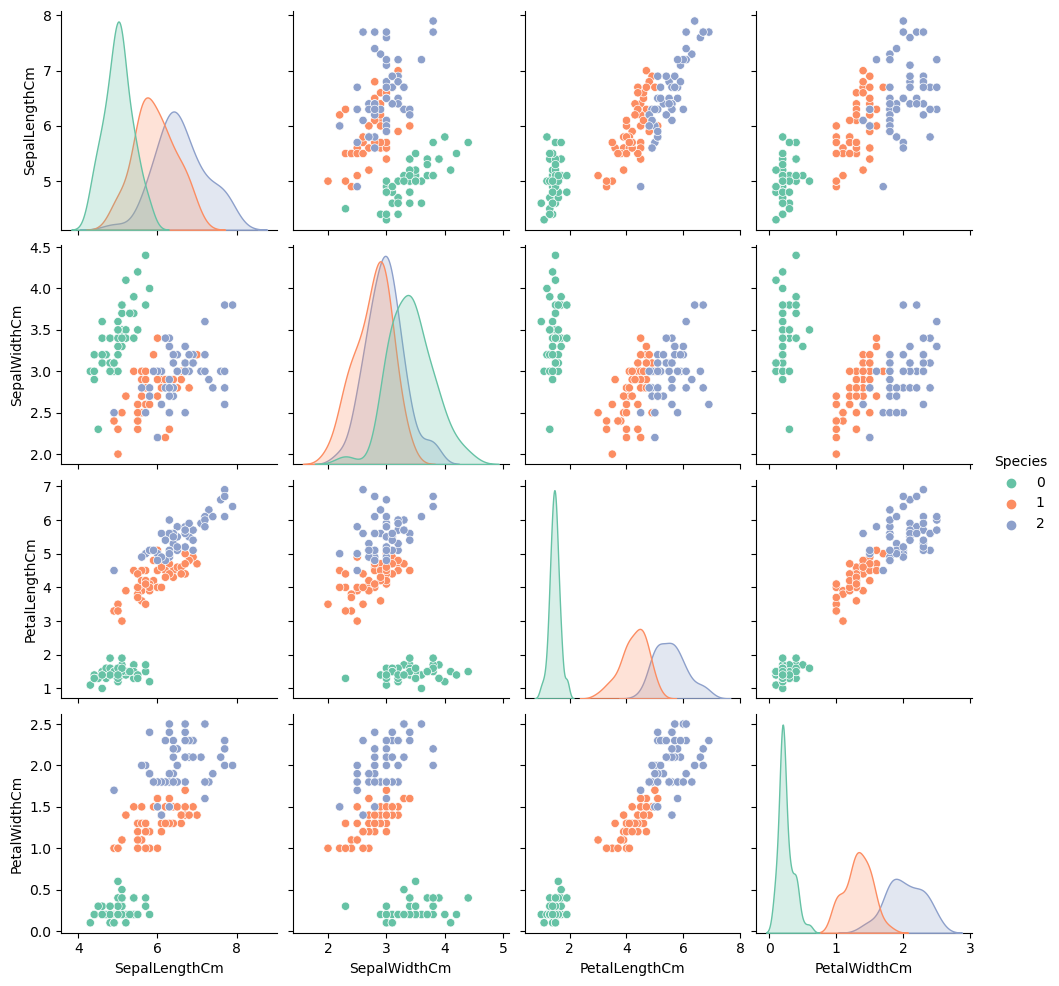

In [132]:
sns.pairplot(df, hue='Species', palette="Set2")

> По графикам видно, что признак petal значительно выделяется среди остальных. По нему будет проще определять класс ириса.

In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SepalLengthCm  150 non-null    float64
 1   SepalWidthCm   150 non-null    float64
 2   PetalLengthCm  150 non-null    float64
 3   PetalWidthCm   150 non-null    float64
 4   Species        150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


In [134]:
df.describe()


,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667,1.000000
std,0.828066,0.433594,1.764420,0.763161,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [135]:
df.groupby('Species').mean()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
Species,,,,
0,5.006,3.418,1.464,0.244
1,5.936,2.770,4.260,1.326
2,6.588,2.974,5.552,2.026


<Axes: >

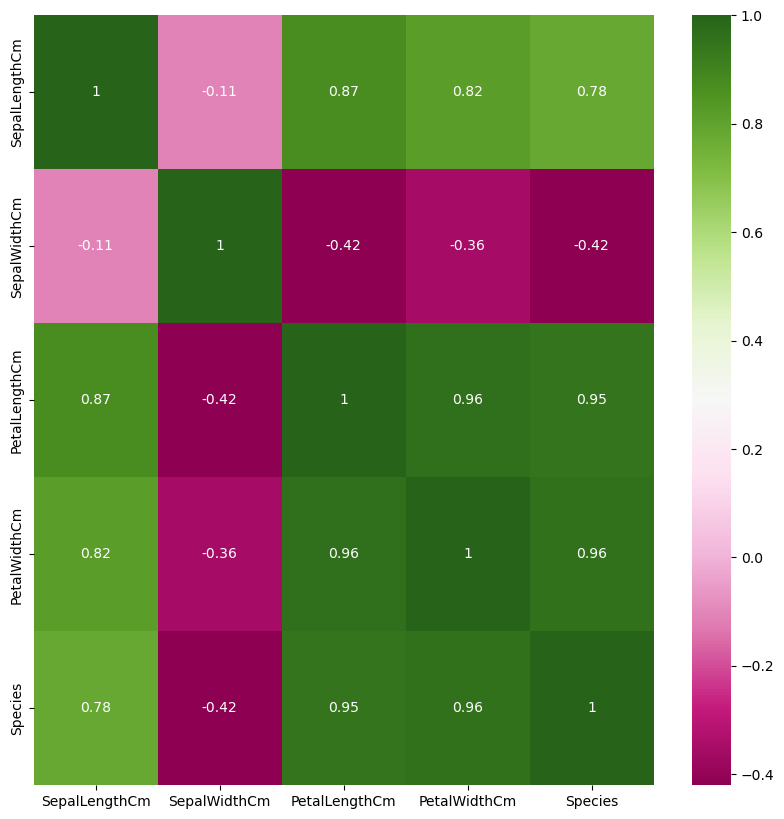

In [136]:
plt.figure(figsize = (10,10))
sns.heatmap(df.corr(), annot=True, cmap="PiYG")

> практически все признаки, кроме SepalWidthCm, сильно коррелируют с зависимой переменной Species. На следующих шагах будет использован RFECV, который изберет подходящие для модели признаки.

## 🚩Разбиение данных с использованием train_test_split. Масштабирование данных.

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=random_state)

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
X_train.head(5)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,-0.206852,-1.158169,0.691238,1.034924
1,0.514724,-0.736249,0.634533,0.771584
2,2.198399,1.584307,1.655229,1.298263
3,0.274199,-0.103370,0.464417,0.244906
4,0.274199,-0.525290,0.521122,-0.018434


## Отбор наилучших признаков при помощи RFECV

In [138]:
rfecv = RFECV(estimator=RidgeClassifierCV())

rfecv.fit(X_train, y_train)

selected_features = list(X_train.columns[rfecv.support_])
print("Optimal features: ", rfecv.n_features_)
print("Selected features: ", selected_features)

Optimal features:  3
Selected features:  ['SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']


In [139]:
X_train = X_train[selected_features]
X_test = X_test[selected_features]

In [140]:
X_train.head(5)

,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,-1.158169,0.691238,1.034924
1,-0.736249,0.634533,0.771584
2,1.584307,1.655229,1.298263
3,-0.103370,0.464417,0.244906
4,-0.525290,0.521122,-0.018434


## Кросс-валидация. Подбор наилучших гиперпараметров

In [141]:
cv = StratifiedKFold(5, shuffle=True, random_state=random_state)

### 1️⃣ Sklearn LogisticRegression

In [142]:
param_grid = {'C': [1E-3, 1E-1, 1, 1E+1, 1E+3]}

searcher = GridSearchCV(LogisticRegression(random_state=random_state), param_grid=param_grid, cv=cv, verbose=5,
                        scoring="roc_auc_ovr", error_score="raise")

searcher = searcher.fit(X_train, y_train)

optimal_logreg_c = searcher.best_params_["C"]
print("Optimal params =", searcher.best_params_)
print("Optimal score =", searcher.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ...........................C=0.001;, score=0.868 total time=   0.0s
[CV 2/5] END ...........................C=0.001;, score=0.905 total time=   0.0s
[CV 3/5] END ...........................C=0.001;, score=0.861 total time=   0.0s
[CV 4/5] END ...........................C=0.001;, score=0.905 total time=   0.0s
[CV 5/5] END ...........................C=0.001;, score=0.927 total time=   0.0s
[CV 1/5] END .............................C=0.1;, score=0.930 total time=   0.0s
[CV 2/5] END .............................C=0.1;, score=0.982 total time=   0.0s
[CV 3/5] END .............................C=0.1;, score=0.938 total time=   0.0s
[CV 4/5] END .............................C=0.1;, score=1.000 total time=   0.0s
[CV 5/5] END .............................C=0.1;, score=1.000 total time=   0.0s
[CV 1/5] END ...............................C=1;, score=0.982 total time=   0.0s
[CV 2/5] END ...............................C=1;,

### 2️⃣ Sklearn SVM

In [143]:
param_grid = {"kernel": ["linear", "rbf"],
              "C": [0.1, 0.25, 0.5, 0.75, 1, 2],
              "gamma": ["scale", "auto", 1E-3, 1E-1, 1, 1E+1, 1E+3]}

searcher = GridSearchCV(SVC(random_state=19, probability=True), param_grid=param_grid, cv=cv, verbose=5,
                        scoring="roc_auc_ovr", error_score="raise")

searcher = searcher.fit(X_train, y_train)

optimal_kernel = searcher.best_params_["kernel"]
optimal_svm_c = searcher.best_params_["C"]
optimal_gamma = searcher.best_params_["gamma"]
print("Optimal params =", searcher.best_params_)
print("Optimal score =", searcher.best_score_)

Fitting 5 folds for each of 84 candidates, totalling 420 fits
[CV 1/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.985 total time=   0.0s
[CV 2/5] END .C=0.1, gamma=scale, kernel=linear;, score=1.000 total time=   0.0s
[CV 3/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.985 total time=   0.0s
[CV 4/5] END .C=0.1, gamma=scale, kernel=linear;, score=1.000 total time=   0.0s
[CV 5/5] END .C=0.1, gamma=scale, kernel=linear;, score=1.000 total time=   0.0s
[CV 1/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.967 total time=   0.0s
[CV 2/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.993 total time=   0.0s
[CV 3/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.973 total time=   0.0s
[CV 4/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=1.000 total time=   0.0s
[CV 5/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=1.000 total time=   0.0s
[CV 1/5] END ..C=0.1, gamma=auto, kernel=linear;, score=0.985 total time=   0.0s
[CV 2/5] END ..C=0.1, gamma=auto, kernel=linear

[CV 5/5] END .C=0.5, gamma=0.001, kernel=linear;, score=1.000 total time=   0.0s
[CV 1/5] END ....C=0.5, gamma=0.001, kernel=rbf;, score=0.780 total time=   0.0s
[CV 2/5] END ....C=0.5, gamma=0.001, kernel=rbf;, score=0.751 total time=   0.0s
[CV 3/5] END ....C=0.5, gamma=0.001, kernel=rbf;, score=0.466 total time=   0.0s
[CV 4/5] END ....C=0.5, gamma=0.001, kernel=rbf;, score=0.389 total time=   0.0s
[CV 5/5] END ....C=0.5, gamma=0.001, kernel=rbf;, score=1.000 total time=   0.0s
[CV 1/5] END ...C=0.5, gamma=0.1, kernel=linear;, score=1.000 total time=   0.0s
[CV 2/5] END ...C=0.5, gamma=0.1, kernel=linear;, score=1.000 total time=   0.0s
[CV 3/5] END ...C=0.5, gamma=0.1, kernel=linear;, score=1.000 total time=   0.0s
[CV 4/5] END ...C=0.5, gamma=0.1, kernel=linear;, score=1.000 total time=   0.0s
[CV 5/5] END ...C=0.5, gamma=0.1, kernel=linear;, score=1.000 total time=   0.0s
[CV 1/5] END ......C=0.5, gamma=0.1, kernel=rbf;, score=0.985 total time=   0.0s
[CV 2/5] END ......C=0.5, ga

[CV 3/5] END ..C=1, gamma=1000.0, kernel=linear;, score=0.996 total time=   0.0s
[CV 4/5] END ..C=1, gamma=1000.0, kernel=linear;, score=1.000 total time=   0.0s
[CV 5/5] END ..C=1, gamma=1000.0, kernel=linear;, score=1.000 total time=   0.0s
[CV 1/5] END .....C=1, gamma=1000.0, kernel=rbf;, score=0.639 total time=   0.0s
[CV 2/5] END .....C=1, gamma=1000.0, kernel=rbf;, score=0.705 total time=   0.0s
[CV 3/5] END .....C=1, gamma=1000.0, kernel=rbf;, score=0.853 total time=   0.0s
[CV 4/5] END .....C=1, gamma=1000.0, kernel=rbf;, score=0.762 total time=   0.0s
[CV 5/5] END .....C=1, gamma=1000.0, kernel=rbf;, score=0.631 total time=   0.0s
[CV 1/5] END ...C=2, gamma=scale, kernel=linear;, score=0.996 total time=   0.0s
[CV 2/5] END ...C=2, gamma=scale, kernel=linear;, score=1.000 total time=   0.0s
[CV 3/5] END ...C=2, gamma=scale, kernel=linear;, score=1.000 total time=   0.0s
[CV 4/5] END ...C=2, gamma=scale, kernel=linear;, score=1.000 total time=   0.0s
[CV 5/5] END ...C=2, gamma=s

### 3️⃣ Sklearn KNN

In [144]:
param_grid = [{"n_neighbors": [3, 5, 7, 9, 11, 13, 15, 17, 19],
               "weights": ['distance', 'uniform']}]

searcher = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=cv, verbose=5,
                        scoring="roc_auc_ovr", error_score="raise")

searcher = searcher.fit(X_train, y_train)

optimal_n_neighbors = searcher.best_params_["n_neighbors"]
optimal_weights = searcher.best_params_["weights"]
print("Optimal params =", str(searcher.best_params_))
print('Optimal score =', searcher.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END ...n_neighbors=3, weights=distance;, score=0.982 total time=   0.0s
[CV 2/5] END ...n_neighbors=3, weights=distance;, score=0.963 total time=   0.0s
[CV 3/5] END ...n_neighbors=3, weights=distance;, score=1.000 total time=   0.0s
[CV 4/5] END ...n_neighbors=3, weights=distance;, score=1.000 total time=   0.0s
[CV 5/5] END ...n_neighbors=3, weights=distance;, score=0.992 total time=   0.0s
[CV 1/5] END ....n_neighbors=3, weights=uniform;, score=0.982 total time=   0.0s
[CV 2/5] END ....n_neighbors=3, weights=uniform;, score=0.963 total time=   0.0s
[CV 3/5] END ....n_neighbors=3, weights=uniform;, score=1.000 total time=   0.0s
[CV 4/5] END ....n_neighbors=3, weights=uniform;, score=1.000 total time=   0.0s
[CV 5/5] END ....n_neighbors=3, weights=uniform;, score=0.996 total time=   0.0s
[CV 1/5] END ...n_neighbors=5, weights=distance;, score=0.982 total time=   0.0s
[CV 2/5] END ...n_neighbors=5, weights=distance;

### 4️⃣ Sklearn Naive Bayes

In [145]:
param_grid = [{"var_smoothing": np.logspace(0, -10, num=100)}]

searcher = GridSearchCV(GaussianNB(), param_grid=param_grid, cv=cv, verbose=5,
                        scoring="roc_auc_ovr", error_score="raise")

searcher = searcher.fit(X_train, y_train)

optimal_var_smoothing = searcher.best_params_["var_smoothing"]
print("Optimal params =", str(searcher.best_params_))
print('Optimal score =', searcher.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END .................var_smoothing=1.0;, score=0.960 total time=   0.0s
[CV 2/5] END .................var_smoothing=1.0;, score=0.985 total time=   0.0s
[CV 3/5] END .................var_smoothing=1.0;, score=0.958 total time=   0.0s
[CV 4/5] END .................var_smoothing=1.0;, score=1.000 total time=   0.0s
[CV 5/5] END .................var_smoothing=1.0;, score=1.000 total time=   0.0s
[CV 1/5] END ..var_smoothing=0.7924828983539173;, score=0.963 total time=   0.0s
[CV 2/5] END ..var_smoothing=0.7924828983539173;, score=0.985 total time=   0.0s
[CV 3/5] END ..var_smoothing=0.7924828983539173;, score=0.962 total time=   0.0s
[CV 4/5] END ..var_smoothing=0.7924828983539173;, score=1.000 total time=   0.0s
[CV 5/5] END ..var_smoothing=0.7924828983539173;, score=1.000 total time=   0.0s
[CV 1/5] END ..var_smoothing=0.6280291441834253;, score=0.971 total time=   0.0s
[CV 2/5] END ..var_smoothing=0.628029144183425

[CV 2/5] END var_smoothing=0.0047508101621027985;, score=1.000 total time=   0.0s
[CV 3/5] END var_smoothing=0.0047508101621027985;, score=0.985 total time=   0.0s
[CV 4/5] END var_smoothing=0.0047508101621027985;, score=1.000 total time=   0.0s
[CV 5/5] END var_smoothing=0.0047508101621027985;, score=1.000 total time=   0.0s
[CV 1/5] END var_smoothing=0.0037649358067924675;, score=0.978 total time=   0.0s
[CV 2/5] END var_smoothing=0.0037649358067924675;, score=1.000 total time=   0.0s
[CV 3/5] END var_smoothing=0.0037649358067924675;, score=0.985 total time=   0.0s
[CV 4/5] END var_smoothing=0.0037649358067924675;, score=1.000 total time=   0.0s
[CV 5/5] END var_smoothing=0.0037649358067924675;, score=1.000 total time=   0.0s
[CV 1/5] END var_smoothing=0.0029836472402833404;, score=0.978 total time=   0.0s
[CV 2/5] END var_smoothing=0.0029836472402833404;, score=1.000 total time=   0.0s
[CV 3/5] END var_smoothing=0.0029836472402833404;, score=0.985 total time=   0.0s
[CV 4/5] END var

[CV 2/5] END var_smoothing=1.788649529057435e-05;, score=1.000 total time=   0.0s
[CV 3/5] END var_smoothing=1.788649529057435e-05;, score=0.985 total time=   0.0s
[CV 4/5] END var_smoothing=1.788649529057435e-05;, score=1.000 total time=   0.0s
[CV 5/5] END var_smoothing=1.788649529057435e-05;, score=1.000 total time=   0.0s
[CV 1/5] END var_smoothing=1.4174741629268048e-05;, score=0.978 total time=   0.0s
[CV 2/5] END var_smoothing=1.4174741629268048e-05;, score=1.000 total time=   0.0s
[CV 3/5] END var_smoothing=1.4174741629268048e-05;, score=0.985 total time=   0.0s
[CV 4/5] END var_smoothing=1.4174741629268048e-05;, score=1.000 total time=   0.0s
[CV 5/5] END var_smoothing=1.4174741629268048e-05;, score=1.000 total time=   0.0s
[CV 1/5] END var_smoothing=1.1233240329780266e-05;, score=0.978 total time=   0.0s
[CV 2/5] END var_smoothing=1.1233240329780266e-05;, score=1.000 total time=   0.0s
[CV 3/5] END var_smoothing=1.1233240329780266e-05;, score=0.985 total time=   0.0s
[CV 4/5]

[CV 1/5] END var_smoothing=4.229242874389499e-08;, score=0.978 total time=   0.0s
[CV 2/5] END var_smoothing=4.229242874389499e-08;, score=1.000 total time=   0.0s
[CV 3/5] END var_smoothing=4.229242874389499e-08;, score=0.985 total time=   0.0s
[CV 4/5] END var_smoothing=4.229242874389499e-08;, score=1.000 total time=   0.0s
[CV 5/5] END var_smoothing=4.229242874389499e-08;, score=1.000 total time=   0.0s
[CV 1/5] END var_smoothing=3.351602650938841e-08;, score=0.978 total time=   0.0s
[CV 2/5] END var_smoothing=3.351602650938841e-08;, score=1.000 total time=   0.0s
[CV 3/5] END var_smoothing=3.351602650938841e-08;, score=0.985 total time=   0.0s
[CV 4/5] END var_smoothing=3.351602650938841e-08;, score=1.000 total time=   0.0s
[CV 5/5] END var_smoothing=3.351602650938841e-08;, score=1.000 total time=   0.0s
[CV 1/5] END var_smoothing=2.6560877829466893e-08;, score=0.978 total time=   0.0s
[CV 2/5] END var_smoothing=2.6560877829466893e-08;, score=1.000 total time=   0.0s
[CV 3/5] END v

[CV 1/5] END ...............var_smoothing=1e-10;, score=0.978 total time=   0.0s
[CV 2/5] END ...............var_smoothing=1e-10;, score=1.000 total time=   0.0s
[CV 3/5] END ...............var_smoothing=1e-10;, score=0.985 total time=   0.0s
[CV 4/5] END ...............var_smoothing=1e-10;, score=1.000 total time=   0.0s
[CV 5/5] END ...............var_smoothing=1e-10;, score=1.000 total time=   0.0s
Optimal params = {'var_smoothing': 0.03853528593710529}
Optimal score = 0.9925518925518926


### 5️⃣ Sklearn Desicion Tree

In [146]:
param_grid = [{"criterion": ["gini", "entropy", "log_loss"],
               "splitter": ["best", "random"],
               "max_depth": [10, 20, 30],
               "min_samples_split": [2, 5, 10],
               "min_samples_leaf": [2, 5, 10],
               "max_features": [2, 5, 10]}]

searcher = GridSearchCV(DecisionTreeClassifier(random_state=19), param_grid=param_grid, cv=cv, verbose=5,
                        scoring="roc_auc_ovr", error_score="raise")

searcher = searcher.fit(X_train, y_train)

optimal_criterion = searcher.best_params_["criterion"]
optimal_splitter = searcher.best_params_["splitter"]
optimal_max_depth = searcher.best_params_["max_depth"]
optimal_min_samples_split = searcher.best_params_["min_samples_split"]
optimal_min_samples_leaf = searcher.best_params_["min_samples_leaf"]
optimal_max_features = searcher.best_params_["max_features"]
print("Optimal params =", str(searcher.best_params_))
print('Optimal score =', searcher.best_score_)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
[CV 1/5] END criterion=gini, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.890 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.996 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.878 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=1.000 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=1.000 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=random;, score=0.960 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=10, max_featu

[CV 5/5] END criterion=gini, max_depth=10, max_features=5, min_samples_leaf=2, min_samples_split=5, splitter=random;, score=1.000 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=10, max_features=5, min_samples_leaf=2, min_samples_split=10, splitter=best;, score=0.890 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=10, max_features=5, min_samples_leaf=2, min_samples_split=10, splitter=best;, score=0.996 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=10, max_features=5, min_samples_leaf=2, min_samples_split=10, splitter=best;, score=0.878 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=10, max_features=5, min_samples_leaf=2, min_samples_split=10, splitter=best;, score=1.000 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=5, min_samples_leaf=2, min_samples_split=10, splitter=best;, score=1.000 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=10, max_features=5, min_samples_leaf=2, min_samples_split=10, splitter=r

[CV 4/5] END criterion=gini, max_depth=10, max_features=10, min_samples_leaf=5, min_samples_split=5, splitter=random;, score=1.000 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=10, min_samples_leaf=5, min_samples_split=5, splitter=random;, score=1.000 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=10, max_features=10, min_samples_leaf=5, min_samples_split=10, splitter=best;, score=0.956 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=10, max_features=10, min_samples_leaf=5, min_samples_split=10, splitter=best;, score=0.996 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=10, max_features=10, min_samples_leaf=5, min_samples_split=10, splitter=best;, score=0.874 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=10, max_features=10, min_samples_leaf=5, min_samples_split=10, splitter=best;, score=1.000 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=10, min_samples_leaf=5, min_samples_split=10, sp

[CV 1/5] END criterion=gini, max_depth=20, max_features=5, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.890 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=20, max_features=5, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.963 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=20, max_features=5, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.878 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=20, max_features=5, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=1.000 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=20, max_features=5, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=1.000 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=20, max_features=5, min_samples_leaf=2, min_samples_split=2, splitter=random;, score=0.956 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=20, max_features=5, min_samples_leaf=2, min_samples_split=2, splitter=random;

[CV 4/5] END criterion=gini, max_depth=20, max_features=10, min_samples_leaf=5, min_samples_split=2, splitter=best;, score=1.000 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=20, max_features=10, min_samples_leaf=5, min_samples_split=2, splitter=best;, score=1.000 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=20, max_features=10, min_samples_leaf=5, min_samples_split=2, splitter=random;, score=0.985 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=20, max_features=10, min_samples_leaf=5, min_samples_split=2, splitter=random;, score=1.000 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=20, max_features=10, min_samples_leaf=5, min_samples_split=2, splitter=random;, score=0.949 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=20, max_features=10, min_samples_leaf=5, min_samples_split=2, splitter=random;, score=1.000 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=20, max_features=10, min_samples_leaf=5, min_samples_split=2, spl

[CV 1/5] END criterion=gini, max_depth=30, max_features=2, min_samples_leaf=2, min_samples_split=10, splitter=random;, score=0.963 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=30, max_features=2, min_samples_leaf=2, min_samples_split=10, splitter=random;, score=1.000 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=30, max_features=2, min_samples_leaf=2, min_samples_split=10, splitter=random;, score=0.957 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=30, max_features=2, min_samples_leaf=2, min_samples_split=10, splitter=random;, score=0.945 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=30, max_features=2, min_samples_leaf=2, min_samples_split=10, splitter=random;, score=1.000 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=2, splitter=best;, score=0.956 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=2, spl

[CV 3/5] END criterion=gini, max_depth=30, max_features=5, min_samples_leaf=10, min_samples_split=2, splitter=best;, score=0.874 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=30, max_features=5, min_samples_leaf=10, min_samples_split=2, splitter=best;, score=1.000 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=30, max_features=5, min_samples_leaf=10, min_samples_split=2, splitter=best;, score=1.000 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=30, max_features=5, min_samples_leaf=10, min_samples_split=2, splitter=random;, score=0.949 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=30, max_features=5, min_samples_leaf=10, min_samples_split=2, splitter=random;, score=1.000 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=30, max_features=5, min_samples_leaf=10, min_samples_split=2, splitter=random;, score=0.949 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=30, max_features=5, min_samples_leaf=10, min_samples_split=2, split

[CV 5/5] END criterion=entropy, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=5, splitter=best;, score=1.000 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=5, splitter=random;, score=0.960 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=5, splitter=random;, score=0.978 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=5, splitter=random;, score=0.957 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=5, splitter=random;, score=0.996 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=5, splitter=random;, score=1.000 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=10, max_features=2, min_samples_leaf=2, min_samp

[CV 2/5] END criterion=entropy, max_depth=10, max_features=2, min_samples_leaf=10, min_samples_split=10, splitter=best;, score=0.989 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=10, max_features=2, min_samples_leaf=10, min_samples_split=10, splitter=best;, score=0.874 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=10, max_features=2, min_samples_leaf=10, min_samples_split=10, splitter=best;, score=1.000 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=10, max_features=2, min_samples_leaf=10, min_samples_split=10, splitter=best;, score=1.000 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=10, max_features=2, min_samples_leaf=10, min_samples_split=10, splitter=random;, score=0.756 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=10, max_features=2, min_samples_leaf=10, min_samples_split=10, splitter=random;, score=0.956 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=10, max_features=2, min_samples_leaf=10, m

[CV 4/5] END criterion=entropy, max_depth=10, max_features=5, min_samples_leaf=5, min_samples_split=5, splitter=random;, score=1.000 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=10, max_features=5, min_samples_leaf=5, min_samples_split=5, splitter=random;, score=1.000 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=10, max_features=5, min_samples_leaf=5, min_samples_split=10, splitter=best;, score=0.956 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=10, max_features=5, min_samples_leaf=5, min_samples_split=10, splitter=best;, score=0.996 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=10, max_features=5, min_samples_leaf=5, min_samples_split=10, splitter=best;, score=0.874 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=10, max_features=5, min_samples_leaf=5, min_samples_split=10, splitter=best;, score=1.000 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=10, max_features=5, min_samples_leaf=5, min_sample

[CV 5/5] END criterion=entropy, max_depth=10, max_features=10, min_samples_leaf=2, min_samples_split=10, splitter=best;, score=1.000 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=10, max_features=10, min_samples_leaf=2, min_samples_split=10, splitter=random;, score=0.956 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=10, max_features=10, min_samples_leaf=2, min_samples_split=10, splitter=random;, score=1.000 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=10, max_features=10, min_samples_leaf=2, min_samples_split=10, splitter=random;, score=0.929 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=10, max_features=10, min_samples_leaf=2, min_samples_split=10, splitter=random;, score=1.000 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=10, max_features=10, min_samples_leaf=2, min_samples_split=10, splitter=random;, score=0.985 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=10, max_features=10, min_samples_lea

[CV 3/5] END criterion=entropy, max_depth=10, max_features=10, min_samples_leaf=10, min_samples_split=10, splitter=best;, score=0.874 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=10, max_features=10, min_samples_leaf=10, min_samples_split=10, splitter=best;, score=1.000 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=10, max_features=10, min_samples_leaf=10, min_samples_split=10, splitter=best;, score=1.000 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=10, max_features=10, min_samples_leaf=10, min_samples_split=10, splitter=random;, score=0.949 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=10, max_features=10, min_samples_leaf=10, min_samples_split=10, splitter=random;, score=1.000 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=10, max_features=10, min_samples_leaf=10, min_samples_split=10, splitter=random;, score=0.949 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=10, max_features=10, min_samples_l

[CV 1/5] END criterion=entropy, max_depth=20, max_features=2, min_samples_leaf=10, min_samples_split=2, splitter=best;, score=0.949 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=20, max_features=2, min_samples_leaf=10, min_samples_split=2, splitter=best;, score=0.989 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=20, max_features=2, min_samples_leaf=10, min_samples_split=2, splitter=best;, score=0.874 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=20, max_features=2, min_samples_leaf=10, min_samples_split=2, splitter=best;, score=1.000 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=20, max_features=2, min_samples_leaf=10, min_samples_split=2, splitter=best;, score=1.000 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=20, max_features=2, min_samples_leaf=10, min_samples_split=2, splitter=random;, score=0.756 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=20, max_features=2, min_samples_leaf=10, min_sampl

[CV 2/5] END criterion=entropy, max_depth=20, max_features=5, min_samples_leaf=2, min_samples_split=10, splitter=random;, score=1.000 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=20, max_features=5, min_samples_leaf=2, min_samples_split=10, splitter=random;, score=0.929 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=20, max_features=5, min_samples_leaf=2, min_samples_split=10, splitter=random;, score=1.000 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=20, max_features=5, min_samples_leaf=2, min_samples_split=10, splitter=random;, score=0.985 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=20, max_features=5, min_samples_leaf=5, min_samples_split=2, splitter=best;, score=0.956 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=20, max_features=5, min_samples_leaf=5, min_samples_split=2, splitter=best;, score=0.996 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=20, max_features=5, min_samples_leaf=5, min_sa

[CV 4/5] END criterion=entropy, max_depth=20, max_features=10, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=1.000 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=20, max_features=10, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=1.000 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=20, max_features=10, min_samples_leaf=2, min_samples_split=2, splitter=random;, score=0.956 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=20, max_features=10, min_samples_leaf=2, min_samples_split=2, splitter=random;, score=1.000 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=20, max_features=10, min_samples_leaf=2, min_samples_split=2, splitter=random;, score=0.929 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=20, max_features=10, min_samples_leaf=2, min_samples_split=2, splitter=random;, score=1.000 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=20, max_features=10, min_samples_leaf=2, min

[CV 1/5] END criterion=entropy, max_depth=20, max_features=10, min_samples_leaf=10, min_samples_split=2, splitter=best;, score=0.949 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=20, max_features=10, min_samples_leaf=10, min_samples_split=2, splitter=best;, score=0.989 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=20, max_features=10, min_samples_leaf=10, min_samples_split=2, splitter=best;, score=0.874 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=20, max_features=10, min_samples_leaf=10, min_samples_split=2, splitter=best;, score=1.000 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=20, max_features=10, min_samples_leaf=10, min_samples_split=2, splitter=best;, score=1.000 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=20, max_features=10, min_samples_leaf=10, min_samples_split=2, splitter=random;, score=0.949 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=20, max_features=10, min_samples_leaf=10, mi

[CV 5/5] END criterion=entropy, max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=2, splitter=best;, score=1.000 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=2, splitter=random;, score=0.926 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=2, splitter=random;, score=0.956 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=2, splitter=random;, score=0.931 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=2, splitter=random;, score=0.945 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=2, splitter=random;, score=1.000 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=30, max_features=2, min_samples_leaf=5, min_samp

[CV 1/5] END criterion=entropy, max_depth=30, max_features=5, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.890 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=30, max_features=5, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.963 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=30, max_features=5, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.878 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=30, max_features=5, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=1.000 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=30, max_features=5, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=1.000 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=30, max_features=5, min_samples_leaf=2, min_samples_split=2, splitter=random;, score=0.956 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=30, max_features=5, min_samples_leaf=2, min_samples_spli

[CV 3/5] END criterion=entropy, max_depth=30, max_features=5, min_samples_leaf=10, min_samples_split=5, splitter=best;, score=0.874 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=30, max_features=5, min_samples_leaf=10, min_samples_split=5, splitter=best;, score=1.000 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=30, max_features=5, min_samples_leaf=10, min_samples_split=5, splitter=best;, score=1.000 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=30, max_features=5, min_samples_leaf=10, min_samples_split=5, splitter=random;, score=0.949 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=30, max_features=5, min_samples_leaf=10, min_samples_split=5, splitter=random;, score=1.000 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=30, max_features=5, min_samples_leaf=10, min_samples_split=5, splitter=random;, score=0.949 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=30, max_features=5, min_samples_leaf=10, min_s

[CV 4/5] END criterion=log_loss, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=10, splitter=random;, score=0.945 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=10, splitter=random;, score=1.000 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=10, max_features=2, min_samples_leaf=5, min_samples_split=2, splitter=best;, score=0.956 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=10, max_features=2, min_samples_leaf=5, min_samples_split=2, splitter=best;, score=0.989 total time=   0.0s
[CV 3/5] END criterion=log_loss, max_depth=10, max_features=2, min_samples_leaf=5, min_samples_split=2, splitter=best;, score=0.874 total time=   0.0s
[CV 4/5] END criterion=log_loss, max_depth=10, max_features=2, min_samples_leaf=5, min_samples_split=2, splitter=best;, score=1.000 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=10, max_features=2, min_samples_leaf=5, min_s

[CV 5/5] END criterion=log_loss, max_depth=10, max_features=2, min_samples_leaf=10, min_samples_split=10, splitter=random;, score=0.853 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=10, max_features=5, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.890 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=10, max_features=5, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.963 total time=   0.0s
[CV 3/5] END criterion=log_loss, max_depth=10, max_features=5, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.878 total time=   0.0s
[CV 4/5] END criterion=log_loss, max_depth=10, max_features=5, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=1.000 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=10, max_features=5, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=1.000 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=10, max_features=5, min_samples_leaf=2, min_sam

[CV 2/5] END criterion=log_loss, max_depth=10, max_features=10, min_samples_leaf=2, min_samples_split=10, splitter=best;, score=0.996 total time=   0.0s
[CV 3/5] END criterion=log_loss, max_depth=10, max_features=10, min_samples_leaf=2, min_samples_split=10, splitter=best;, score=0.878 total time=   0.0s
[CV 4/5] END criterion=log_loss, max_depth=10, max_features=10, min_samples_leaf=2, min_samples_split=10, splitter=best;, score=1.000 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=10, max_features=10, min_samples_leaf=2, min_samples_split=10, splitter=best;, score=1.000 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=10, max_features=10, min_samples_leaf=2, min_samples_split=10, splitter=random;, score=0.956 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=10, max_features=10, min_samples_leaf=2, min_samples_split=10, splitter=random;, score=1.000 total time=   0.0s
[CV 3/5] END criterion=log_loss, max_depth=10, max_features=10, min_samples_le

[CV 1/5] END criterion=log_loss, max_depth=20, max_features=2, min_samples_leaf=5, min_samples_split=5, splitter=random;, score=0.926 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=20, max_features=2, min_samples_leaf=5, min_samples_split=5, splitter=random;, score=0.956 total time=   0.0s
[CV 3/5] END criterion=log_loss, max_depth=20, max_features=2, min_samples_leaf=5, min_samples_split=5, splitter=random;, score=0.931 total time=   0.0s
[CV 4/5] END criterion=log_loss, max_depth=20, max_features=2, min_samples_leaf=5, min_samples_split=5, splitter=random;, score=0.945 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=20, max_features=2, min_samples_leaf=5, min_samples_split=5, splitter=random;, score=1.000 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=20, max_features=2, min_samples_leaf=5, min_samples_split=10, splitter=best;, score=0.956 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=20, max_features=2, min_samples_leaf=5, 

[CV 4/5] END criterion=log_loss, max_depth=20, max_features=5, min_samples_leaf=10, min_samples_split=5, splitter=best;, score=1.000 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=20, max_features=5, min_samples_leaf=10, min_samples_split=5, splitter=best;, score=1.000 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=20, max_features=5, min_samples_leaf=10, min_samples_split=5, splitter=random;, score=0.949 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=20, max_features=5, min_samples_leaf=10, min_samples_split=5, splitter=random;, score=1.000 total time=   0.0s
[CV 3/5] END criterion=log_loss, max_depth=20, max_features=5, min_samples_leaf=10, min_samples_split=5, splitter=random;, score=0.949 total time=   0.0s
[CV 4/5] END criterion=log_loss, max_depth=20, max_features=5, min_samples_leaf=10, min_samples_split=5, splitter=random;, score=0.977 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=20, max_features=5, min_samples_leaf=

[CV 5/5] END criterion=log_loss, max_depth=30, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=random;, score=1.000 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=30, max_features=2, min_samples_leaf=2, min_samples_split=5, splitter=best;, score=0.890 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=30, max_features=2, min_samples_leaf=2, min_samples_split=5, splitter=best;, score=0.996 total time=   0.0s
[CV 3/5] END criterion=log_loss, max_depth=30, max_features=2, min_samples_leaf=2, min_samples_split=5, splitter=best;, score=0.878 total time=   0.0s
[CV 4/5] END criterion=log_loss, max_depth=30, max_features=2, min_samples_leaf=2, min_samples_split=5, splitter=best;, score=1.000 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=30, max_features=2, min_samples_leaf=2, min_samples_split=5, splitter=best;, score=1.000 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=30, max_features=2, min_samples_leaf=2, min_sampl

[CV 3/5] END criterion=log_loss, max_depth=30, max_features=5, min_samples_leaf=5, min_samples_split=5, splitter=best;, score=0.874 total time=   0.0s
[CV 4/5] END criterion=log_loss, max_depth=30, max_features=5, min_samples_leaf=5, min_samples_split=5, splitter=best;, score=1.000 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=30, max_features=5, min_samples_leaf=5, min_samples_split=5, splitter=best;, score=1.000 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=30, max_features=5, min_samples_leaf=5, min_samples_split=5, splitter=random;, score=0.985 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=30, max_features=5, min_samples_leaf=5, min_samples_split=5, splitter=random;, score=1.000 total time=   0.0s
[CV 3/5] END criterion=log_loss, max_depth=30, max_features=5, min_samples_leaf=5, min_samples_split=5, splitter=random;, score=0.949 total time=   0.0s
[CV 4/5] END criterion=log_loss, max_depth=30, max_features=5, min_samples_leaf=5, min_s

[CV 5/5] END criterion=log_loss, max_depth=30, max_features=10, min_samples_leaf=10, min_samples_split=5, splitter=random;, score=0.977 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=30, max_features=10, min_samples_leaf=10, min_samples_split=10, splitter=best;, score=0.949 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=30, max_features=10, min_samples_leaf=10, min_samples_split=10, splitter=best;, score=0.989 total time=   0.0s
[CV 3/5] END criterion=log_loss, max_depth=30, max_features=10, min_samples_leaf=10, min_samples_split=10, splitter=best;, score=0.874 total time=   0.0s
[CV 4/5] END criterion=log_loss, max_depth=30, max_features=10, min_samples_leaf=10, min_samples_split=10, splitter=best;, score=1.000 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=30, max_features=10, min_samples_leaf=10, min_samples_split=10, splitter=best;, score=1.000 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=30, max_features=10, min_samples

## Реализация стратегий OneVsRest, OneVsOne и OutputCode

In [147]:
def measure_time(model, X, y):
    return cross_validate(model, X, y, cv=5)["fit_time"].mean()

statdf = pd.DataFrame(columns=['Strategy','Method','Accuracy','Time'])
statdf

,Strategy,Method,Accuracy,Time


 ## 1. OneVsRest

In [148]:
from sklearn.multiclass import OneVsRestClassifier

 ### Logistic Regression

In [149]:
ovr_logreg = OneVsRestClassifier(LogisticRegression(C=optimal_logreg_c, random_state=19)).fit(X_train, y_train)
accuracy = accuracy_score(y_test, ovr_logreg.predict(X_test))
time = measure_time(ovr_logreg, X_train, y_train)

statdf.loc[len(statdf.index)] = ['OneVsRest', 'Logistic Regression', accuracy, time]

 ### SVM

In [150]:
ovr_svm = OneVsRestClassifier(SVC(kernel=optimal_kernel, C=optimal_svm_c, 
                              gamma=optimal_gamma, random_state=19, probability=True)).fit(X_train, y_train)
accuracy = accuracy_score(y_test, ovr_svm.predict(X_test))
time = measure_time(ovr_svm, X_train, y_train)

statdf.loc[len(statdf.index)] = ['OneVsRest', 'SVM', accuracy, time]

 ### KNN

In [151]:
ovr_knn = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=optimal_n_neighbors)).fit(X_train, y_train)
accuracy = accuracy_score(y_test, ovr_knn.predict(X_test))
time = measure_time(ovr_knn, X_train, y_train)

statdf.loc[len(statdf.index)] = ['OneVsRest', 'KNN', accuracy, time]

 ### Naive Bayes

In [152]:
ovr_nb = OneVsRestClassifier(GaussianNB(var_smoothing=optimal_var_smoothing)).fit(X_train, y_train)
accuracy = accuracy_score(y_test, ovr_nb.predict(X_test))
time = measure_time(ovr_nb, X_train, y_train)

statdf.loc[len(statdf.index)] = ['OneVsRest', 'Naive Bayes', accuracy, time]

 ### Decision Tree

In [153]:
ovr_dt = OneVsRestClassifier(DecisionTreeClassifier(criterion=optimal_criterion, max_depth=optimal_max_depth,
                                                    max_features=optimal_max_features, min_samples_leaf=optimal_min_samples_leaf,
                                                    min_samples_split=optimal_min_samples_split, splitter=optimal_splitter, 
                                                    random_state=19)).fit(X_train, y_train)
accuracy = accuracy_score(y_test, ovr_dt.predict(X_test))
time = measure_time(ovr_dt, X_train, y_train)

statdf.loc[len(statdf.index)] = ['OneVsRest', 'Decision Tree', accuracy, time]
statdf

,Strategy,Method,Accuracy,Time
0,OneVsRest,Logistic Regression,1.00,0.003818
1,OneVsRest,SVM,0.98,0.002888
2,OneVsRest,KNN,0.94,0.001826
3,OneVsRest,Naive Bayes,1.00,0.002141
4,OneVsRest,Decision Tree,0.90,0.002159


 ## 2. OneVsOne

In [154]:
from sklearn.multiclass import OneVsOneClassifier

 ### Logistic Regression

In [155]:
ovo_logreg = OneVsOneClassifier(LogisticRegression(C=optimal_logreg_c, random_state=19)).fit(X_train, y_train)
accuracy = accuracy_score(y_test, ovo_logreg.predict(X_test))
time = measure_time(ovo_logreg, X_train, y_train)

statdf.loc[len(statdf.index)] = ['OneVsOne', 'Logistic Regression', accuracy, time]

### SVM

In [156]:
ovo_svm = OneVsOneClassifier(SVC(kernel=optimal_kernel, C=optimal_svm_c, gamma=optimal_gamma, random_state=19, probability=True)).fit(X_train, y_train)
accuracy = accuracy_score(y_test, ovo_svm.predict(X_test))
time = measure_time(ovo_svm, X_train, y_train)

statdf.loc[len(statdf.index)] = ['OneVsOne', 'SVM', accuracy, time]

### KNN

In [157]:
ovo_knn = OneVsOneClassifier(KNeighborsClassifier(n_neighbors=optimal_n_neighbors)).fit(X_train, y_train)
accuracy = accuracy_score(y_test, ovo_knn.predict(X_test))
time = measure_time(ovo_knn, X_train, y_train)

statdf.loc[len(statdf.index)] = ['OneVsOne', 'KNN', accuracy, time]

 ### Naive Bayes

In [158]:
ovo_nb = OneVsOneClassifier(GaussianNB(var_smoothing=optimal_var_smoothing)).fit(X_train, y_train)
accuracy = accuracy_score(y_test, ovo_nb.predict(X_test))
time = measure_time(ovo_nb, X_train, y_train)

statdf.loc[len(statdf.index)] = ['OneVsOne', 'Naive Bayes', accuracy, time]

 ### Decision Tree

In [159]:
ovo_dt = OneVsOneClassifier(DecisionTreeClassifier(criterion=optimal_criterion, max_depth=optimal_max_depth,
                                                    max_features=optimal_max_features, min_samples_leaf=optimal_min_samples_leaf,
                                                    min_samples_split=optimal_min_samples_split, splitter=optimal_splitter, random_state=19)).fit(X_train, y_train)
accuracy = accuracy_score(y_test, ovo_dt.predict(X_test))
time = measure_time(ovo_dt, X_train, y_train)

statdf.loc[len(statdf.index)] = ['OneVsOne', 'Decision Tree', accuracy, time]

In [160]:
statdf

,Strategy,Method,Accuracy,Time
0,OneVsRest,Logistic Regression,1.00,0.003818
1,OneVsRest,SVM,0.98,0.002888
2,OneVsRest,KNN,0.94,0.001826
3,OneVsRest,Naive Bayes,1.00,0.002141
4,OneVsRest,Decision Tree,0.90,0.002159
5,OneVsOne,Logistic Regression,0.98,0.003150
6,OneVsOne,SVM,0.98,0.002352
7,OneVsOne,KNN,0.94,0.002527
8,OneVsOne,Naive Bayes,1.00,0.003429
9,OneVsOne,Decision Tree,0.94,0.003103


## 3. OutputCode

In [161]:
from sklearn.multiclass import OutputCodeClassifier

### Logistic Regression

In [162]:
oc_logreg = OutputCodeClassifier(LogisticRegression(C=optimal_logreg_c, random_state=19)).fit(X_train, y_train)
accuracy = accuracy_score(y_test, oc_logreg.predict(X_test))
time = measure_time(oc_logreg, X_train, y_train)

statdf.loc[len(statdf.index)] = ['OutputCode', 'Logistic Regression', accuracy, time]

### SVM

In [163]:
oc_svm = OutputCodeClassifier(SVC(kernel=optimal_kernel, C=optimal_svm_c, gamma=optimal_gamma, random_state=19, probability=True)).fit(X_train, y_train)
accuracy = accuracy_score(y_test, oc_svm.predict(X_test))
time = measure_time(oc_svm, X_train, y_train)

statdf.loc[len(statdf.index)] = ['OutputCode', 'SVM', accuracy, time]

### KNN

In [164]:
oc_knn = OutputCodeClassifier(KNeighborsClassifier(n_neighbors=optimal_n_neighbors)).fit(X_train, y_train)
accuracy = accuracy_score(y_test, oc_knn.predict(X_test))
time = measure_time(oc_knn, X_train, y_train)

statdf.loc[len(statdf.index)] = ['OutputCode', 'KNN', accuracy, time]

### Naive Bayes

In [165]:
oc_nb = OutputCodeClassifier(GaussianNB(var_smoothing=optimal_var_smoothing)).fit(X_train, y_train)
accuracy = accuracy_score(y_test, oc_nb.predict(X_test))
time = measure_time(oc_nb, X_train, y_train)

statdf.loc[len(statdf.index)] = ['OutputCode', 'Naive Bayes', accuracy, time]

### Decision Tree

In [166]:
oc_dt = OutputCodeClassifier(DecisionTreeClassifier(criterion=optimal_criterion, max_depth=optimal_max_depth,
                                                   max_features=optimal_max_features, min_samples_leaf=optimal_min_samples_leaf,
                                                   min_samples_split=optimal_min_samples_split, splitter=optimal_splitter, random_state=19)).fit(X_train, y_train)
accuracy = accuracy_score(y_test, oc_dt.predict(X_test))
time = measure_time(oc_dt, X_train, y_train)

statdf.loc[len(statdf.index)] = ['OutputCode', 'Descision Tree', accuracy, time]

In [167]:
statdf

,Strategy,Method,Accuracy,Time
0,OneVsRest,Logistic Regression,1.00,0.003818
1,OneVsRest,SVM,0.98,0.002888
2,OneVsRest,KNN,0.94,0.001826
3,OneVsRest,Naive Bayes,1.00,0.002141
4,OneVsRest,Decision Tree,0.90,0.002159
5,OneVsOne,Logistic Regression,0.98,0.003150
6,OneVsOne,SVM,0.98,0.002352
7,OneVsOne,KNN,0.94,0.002527
8,OneVsOne,Naive Bayes,1.00,0.003429
9,OneVsOne,Decision Tree,0.94,0.003103


### Результаты
Наиболее точные результаты показали стратегии **OneVsRest** и **OneVsOne**, по скорости исполнения быстрее все-таки оказалась **OneVsOne**. Менее точные и наиболее долгие показатели у стратегии **OutputCode**.  
Лучшей по точности и времени среди всех реализаций моделей оказалась модель **Наивного байеса** в стратегии **OneVsOne**.  
Худшей реализацией оказалась модель **KNN** в стратегии **OutputCode**.